In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplt_style_n
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use(mplt_style_n.style1)

import scipy

In [2]:
import shapely

### importing the functions constructed for this project

In [3]:
import report_functions as rf

#### Loading the dataframe

In [4]:
df = pd.read_csv('waterquality.csv', low_memory=False, index_col=0);

/home/nannil/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 0) Dataset analysis (structures, lower limits, outliers...)

### 0.a) Subset of the dataset

The dataset is very big, we construct a subset with the information we want to study, i.e. water and weather conditions/properties, and phosphate and nitrogen based nutrients

In [5]:
serch_for = ["water", "liquid", "salinity", "tide", "weather", "depth", "river", "sewage", "estuary"]

In [6]:
water_determinants = np.unique(df[df["determinand.definition"].str.contains('|'.join(serch_for), case=False)==True]["determinand.definition"])

In [7]:
nutrients_N = [119,111,9993,117,9853,118,6485,4925,114,116,9943,9686 ] #12 determinands linked to  Nitrogen
nutrients_P = [9856, 180, 348] # 3 determinants linked to the Phosphate
nutrients_Chl_Salinity = [947, 7608]

In [8]:
Nutrients_N_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_N)]["determinand.definition"]))
Nutrients_P_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_P)]["determinand.definition"]))
Nutrients_Chl_Salinity_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_Chl_Salinity)]["determinand.definition"]))

#### Here we create a subset of the dataframe only looking at results about water and nutrients linked to nitrogen and phosphate

In [9]:
df_sub = df.loc[(df['determinand.definition'].isin(water_determinants)) | (df['determinand.notation'].isin(nutrients_N)| (df['determinand.notation'].isin(nutrients_P)| (df['determinand.notation'].isin(nutrients_Chl_Salinity)))) ]


#### Add a Date column, so ignoring the time

In [10]:
df_sub.loc[:, "Date"] = pd.to_datetime(df_sub['sample.sampleDateTime']).dt.date.values


### 0.b) Studying the lower limits

#### when resultQualifier.notation is "<", the value is a lower limit. We substitue these values with 0. 

In [11]:
df_sub.loc[:,"resultQualifier.notation"] = np.where(df_sub["resultQualifier.notation"]=="<", 0, 1)


In [12]:
df_sub.loc[df_sub["resultQualifier.notation"]==0, "result"] = 0

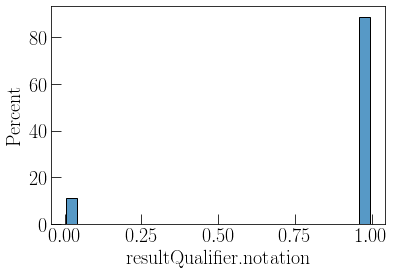

In [13]:
sns.histplot(df_sub, x="resultQualifier.notation", stat="percent", multiple="dodge", shrink=.8);


### 0.c) Pivoting the dataset, to have a dataframe where the analysis results are on the columns

#### since it is a big dataframe, we also exclude columns that are not important for the analysis before pivoting


In [14]:
df_sub_drop = df_sub.drop(columns=['@id', 'sample.samplingPoint', 'determinand.notation', 'determinand.label', 'sample.sampleDateTime', 'determinand.unit.label',"codedResultInterpretation.interpretation","resultQualifier.notation", 'sample.isComplianceSample' , 'sample.purpose.label'])

### 0.c) Pivoting the dataset, to have a dataframe where the analysis results are on the columns

In [15]:
df_piv = df_sub_drop.pivot_table('result',\
list(df_sub_drop.drop(columns=['result', 'determinand.definition']).columns), 'determinand.definition').reset_index().rename_axis(None, axis=1)



#### Studying the NaNs

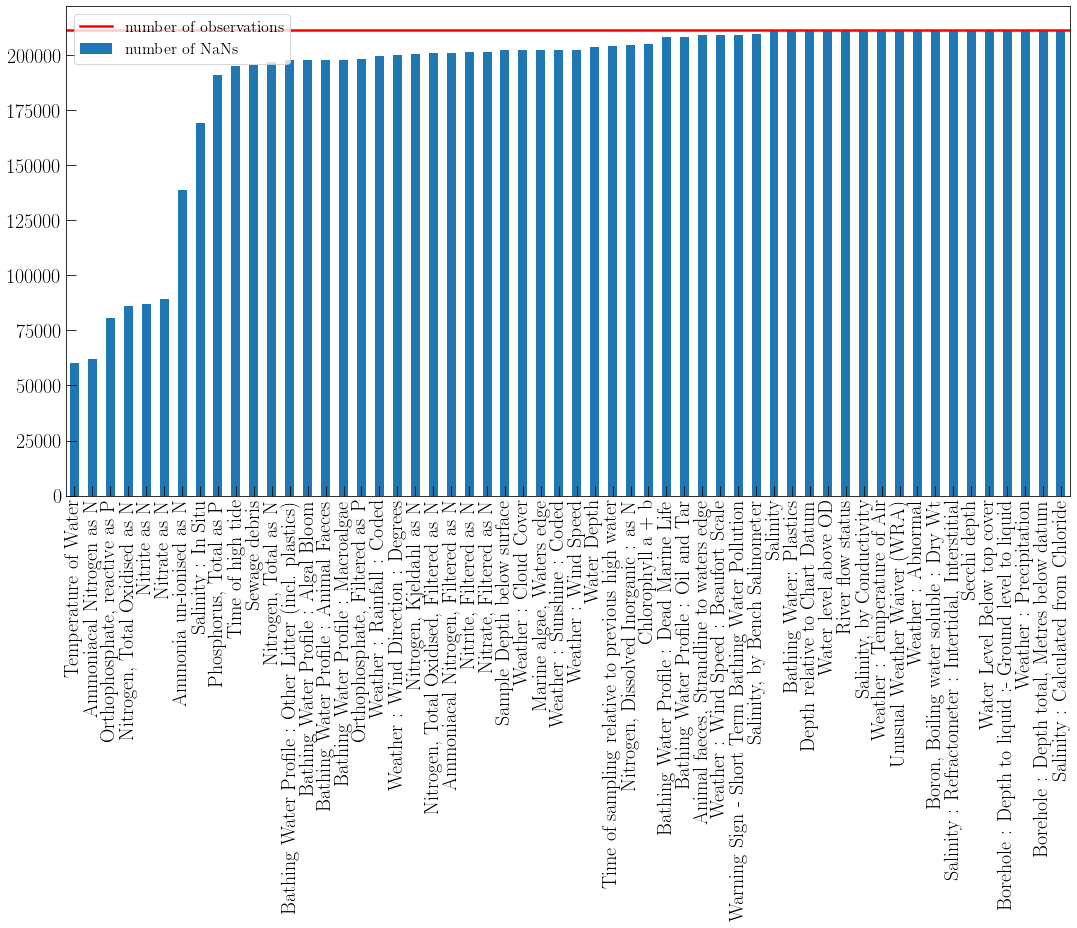

In [16]:
missing = df_piv.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots(figsize=(18,9))


missing.plot.bar(label="number of NaNs");
plt.axhline(y=df_piv.shape[0], color="red", label="number of observations")
plt.legend(fontsize=16);

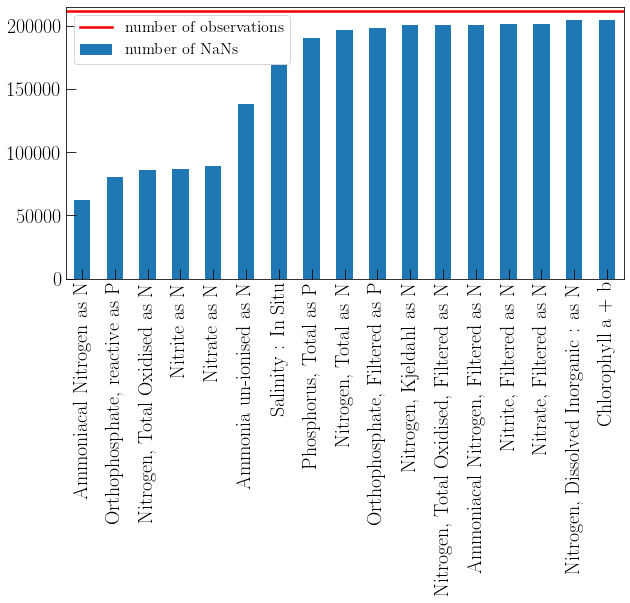

In [17]:
missing = df_piv[Nutrients_N_names+Nutrients_P_names+Nutrients_Chl_Salinity_names].isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots(figsize=(10,5))


missing.plot.bar(label="number of NaNs");
plt.axhline(y=df_piv.shape[0], color="red", label="number of observations")
plt.legend(fontsize=16);

#### Encoding Season
##### following the Langstone Report, we devide the year in two seasons (aprile-september as summer, and october-march as winter)

In [18]:
df_piv.loc[:,"year"] = pd.to_datetime(df_piv['Date']).dt.year


In [19]:
df_piv.loc[:,"month"] = pd.to_datetime(df_piv['Date']).dt.month


In [20]:
df_piv["season"] = np.where((df_piv["month"]>4)&(df_piv["month"]<9), 0, 1)

In [21]:
df_piv = df_piv.sort_values(by="Date", ascending=True)

#### Studying NaNs and their distribution in time

In [22]:
import missingno as msno  # # pip install missingno


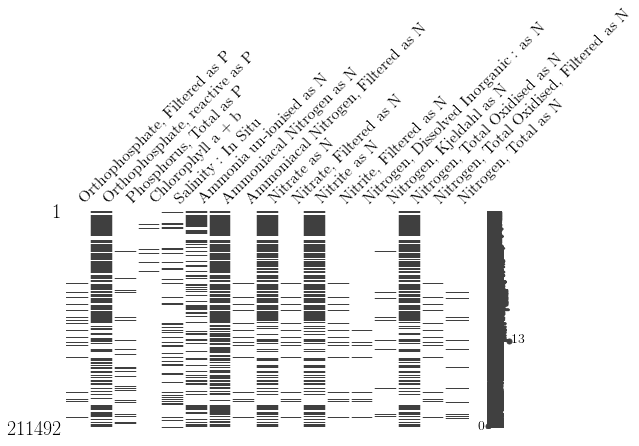

In [23]:
msno.matrix(df_piv[Nutrients_P_names+Nutrients_Chl_Salinity_names+Nutrients_N_names], figsize=(8,4));

### 0.d) Studying the outliers

#### The outliers are defined as the measure with quantiles > 0.01 and 0.99

In [24]:
df_piv_out = rf.quantiles_check(df_piv, Nutrients_N_names + Nutrients_P_names+Nutrients_Chl_Salinity_names)

### 0.e) Studying the water-types distributions in the dataset

#### List of the water-types present in the dataset

In [25]:
set(np.unique(df_piv_out["sample.sampledMaterialType.label"]))

{'ANY BIOTA',
 'ANY LEACHATE',
 'ANY NON-AQUEOUS LIQUID',
 'ANY SEWAGE',
 'ANY SEWAGE SLUDGE',
 'ANY SOLID/SEDIMENT - UNSPECIFIED',
 'ANY TRADE EFFLUENT',
 'ANY WATER',
 'CANAL WATER',
 'CERASTODERMA EDULE - COCKLE - WHOLE ANIMAL',
 'COASTAL / MARINE SEDIMENT',
 'COASTAL / MARINE SEDIMENT - <63UM FRACTION',
 'CRUDE SEWAGE',
 'ESTUARINE WATER',
 'ESTUARINE WATER AT HIGH TIDE',
 'ESTUARY SEDIMENT',
 'ESTUARY SEDIMENT - <63UM FRACTION',
 'ESTUARY SEDIMENT - INTER TIDAL',
 'ESTUARY SEDIMENT - INTER TIDAL - <63UM FRACTION',
 'ESTUARY SEDIMENT - SUB TIDAL',
 'FINAL SEWAGE EFFLUENT',
 'GROUNDWATER',
 'GROUNDWATER - PURGED/PUMPED/REFILLED',
 'MYTILUS EDULIS - MUSSEL - WHOLE ANIMAL',
 'OSTEREA EDULIS - NATIVE OYSTER - WHOLE ANIMAL',
 'POND / LAKE / RESERVOIR WATER',
 'PRECIPITATION',
 'RIVER / RUNNING SURFACE WATER',
 'RUNNING SURFACE WATER SEDIMENT',
 'RUNNING SURFACE WATER SEDIMENT - <63UM FRACTION',
 'SEA WATER',
 'STORM SEWER OVERFLOW DISCHARGE',
 'STORM TANK EFFLUENT',
 'SURFACE DRAINAGE',

#### List of the water-types in the dataset and the number of times they appear in the dataset

In [26]:
df_piv_out.groupby(["sample.sampledMaterialType.label"]).count().sort_values(by="sample.samplingPoint.notation", ascending=False)["sample.samplingPoint.notation"]#.index.get_level_values("sample.sampledMaterialType.label")

sample.sampledMaterialType.label
RIVER / RUNNING SURFACE WATER                      86083
FINAL SEWAGE EFFLUENT                              51892
SEA WATER                                          32684
ESTUARINE WATER                                    14131
ANY TRADE EFFLUENT                                  9262
GROUNDWATER                                         4819
CRUDE SEWAGE                                        3418
POND / LAKE / RESERVOIR WATER                       2417
SURFACE DRAINAGE                                    2181
TRADE EFFLUENT - FRESHWATER RETURNED ABSTRACTED     1230
ANY SEWAGE                                           928
ANY WATER                                            667
UNCODED                                              477
CANAL WATER                                          415
COASTAL / MARINE SEDIMENT - <63UM FRACTION           169
STORM SEWER OVERFLOW DISCHARGE                       161
ESTUARINE WATER AT HIGH TIDE                         14

In [27]:
water_names = df_piv_out.groupby(["sample.sampledMaterialType.label"]).count().sort_values(by="sample.samplingPoint.notation", ascending=False)["sample.samplingPoint.notation"].index.get_level_values("sample.sampledMaterialType.label")

In [28]:
frequency = df_piv_out[["year", "sample.sampledMaterialType.label"]]

In [29]:
data = frequency.groupby(["year","sample.sampledMaterialType.label"]).size()


In [30]:
from matplotlib import cm


In [31]:
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(df_sub["sample.sampledMaterialType.label"]))))



#### Frequency in time of the water-types label in the catalogue 

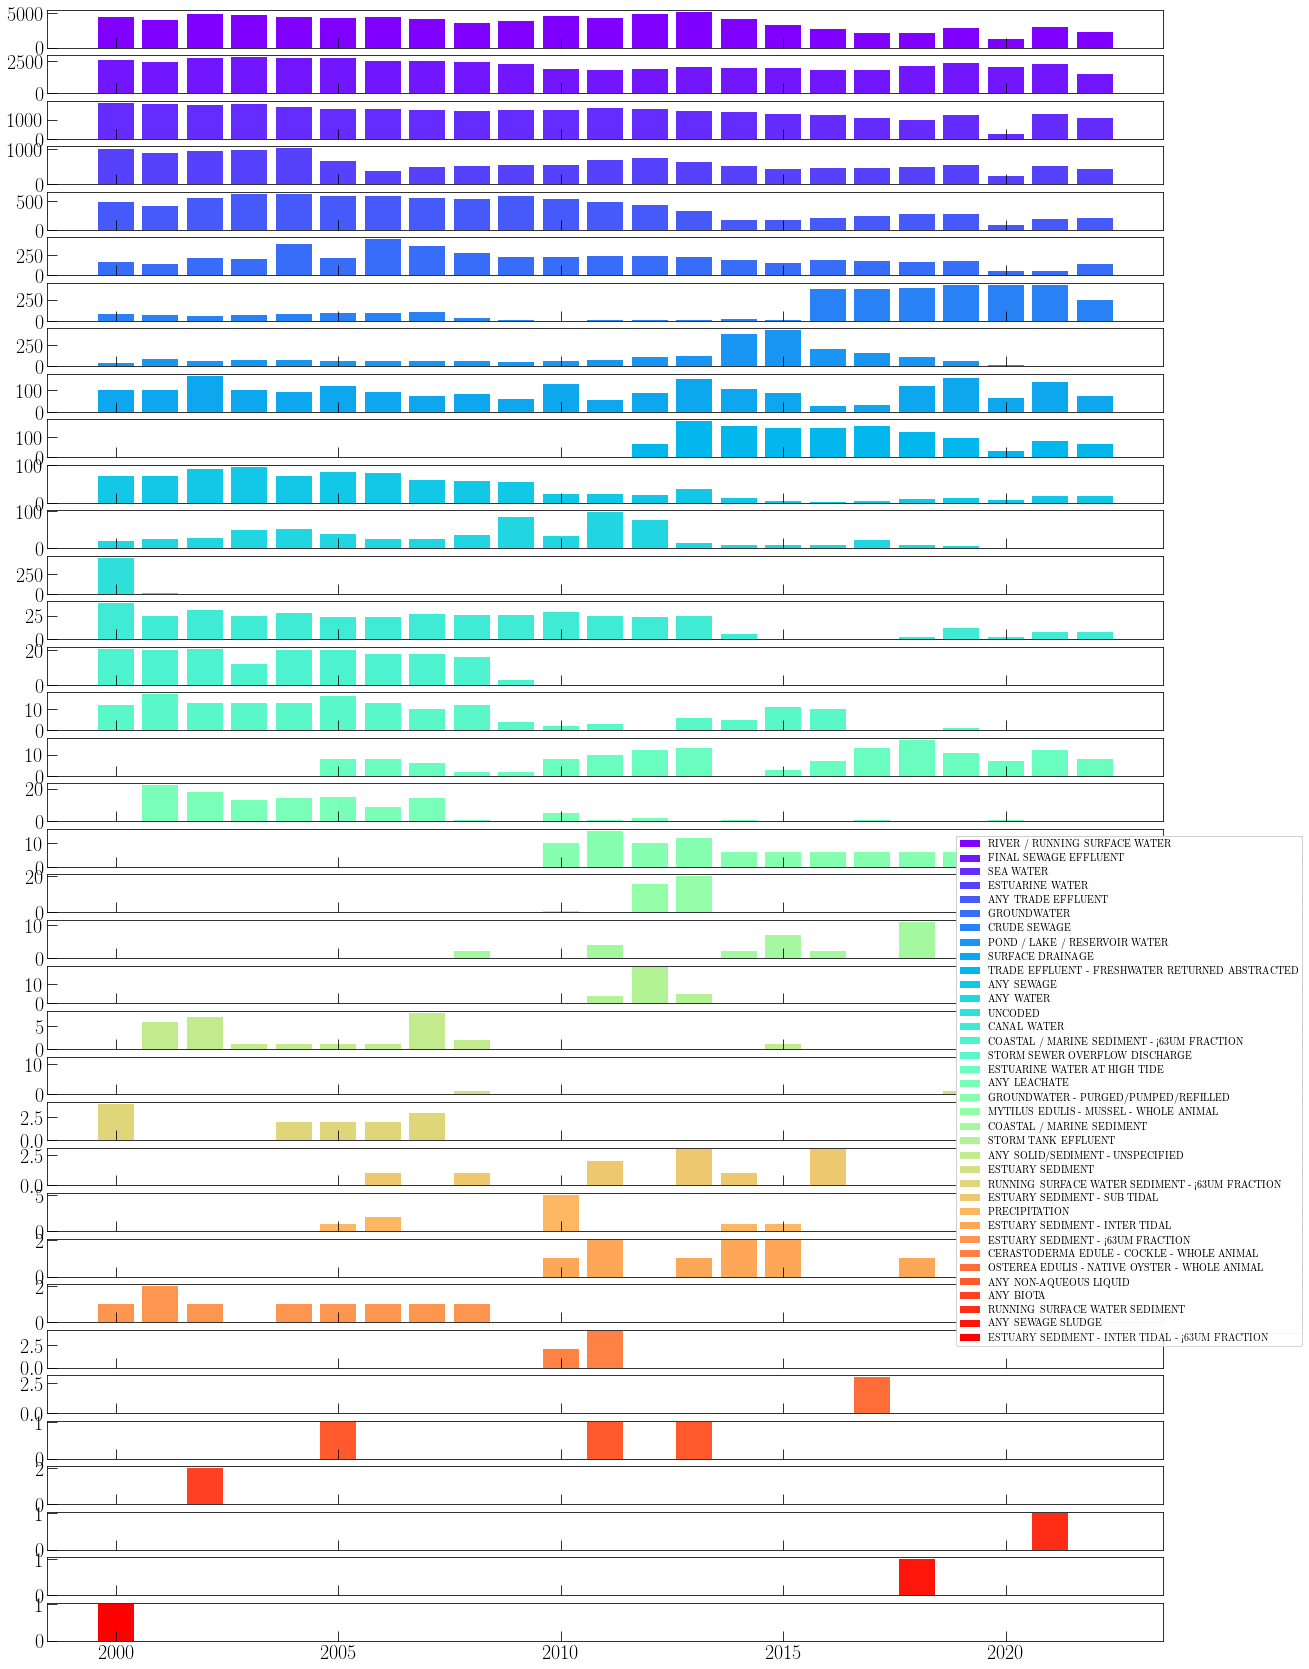

In [32]:
    fig, axes = plt.subplots(nrows=len(water_names),ncols=1, sharex=True, figsize=(20,30))
    for i in range(len(water_names)):
        axes[i].bar(data[(data.index.get_level_values("sample.sampledMaterialType.label") == \
                          water_names[i])].index.get_level_values('year'), \
                    data.loc[(data.index.get_level_values("sample.sampledMaterialType.label") ==\
                             water_names[i])].values, label = water_names[i], color=colors[i])
        fig.legend(bbox_to_anchor=(1., .5))
        fig.set_facecolor("w")

        plt.savefig('WaterType_frequency.png', bbox_inches='tight',  transparent=False)


#### Let's keep a subset of the dataset where only the first 4 most frequent labels for the water

In [33]:
list(water_names[0:4])

['RIVER / RUNNING SURFACE WATER',
 'FINAL SEWAGE EFFLUENT',
 'SEA WATER',
 'ESTUARINE WATER']

In [34]:
df_water = df_piv_out[df_piv_out["sample.sampledMaterialType.label"].isin(list(water_names[0:4]))]

#### Almost 90% of the catalogue has these 4 labels:

In [35]:
(np.shape(df_water)[0]/np.shape(df_piv_out)[0]) 

0.8737446333667467

# 1) Repeating the Langstone report analysis
### Summary of Langstone Harbour 2020 dynamic CPM modelling
### Final Version – April 2021

In [36]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Polygon


## 1.a) Portsmouth district

#### Data from here https://www.opendoorlogistics.com/downloads/

In [44]:
uk_district = gpd.read_file('./Distribution/Districts.shp')
PO_district_oi = ["PO1", "PO2", "PO3", "PO5", "PO4", "PO6", "PO9", "PO10", "PO11"]

PO_district = uk_district[(uk_district['name'].isin(PO_district_oi) )].geometry

PO_district = PO_district.to_crs(4326)

In [45]:
list_loc_langstone = ["SO-G0003493", "SO-G0016920","SO-G0003484","SO-G0016918","SO-G0015927",\
                              "SO-G0003468","SO-G0003467","SO-G0016921","SO-G0003473", "SO-G0003616", "SO-G0003625", "SO-G0003368", "SO-G0003508","SO-G0003484","SO-G0016873","SO-Y0003370"]

### 1.b) Subset of the dataset based on the locations in the Langstone report

In [46]:
df_langstone_report = df_water[df_water["sample.samplingPoint.notation"].isin(list_loc_langstone)]

### 1.c) Divide this subset in sewage, freshwater, ocean, estuarine as in the report

In [47]:
gdf_loc = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_langstone_report["sample.samplingPoint.easting"], \
                                                      df_langstone_report["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

In [48]:
df_fw = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[0]]
df_sew = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[1]]
df_ocean = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[2]]
df_est = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[3]]

In [49]:
gdf_freshwater = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_fw["sample.samplingPoint.easting"], \
                                                      df_fw["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

In [50]:
gdf_sewage = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_sew["sample.samplingPoint.easting"], \
                                                      df_sew["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

In [51]:
gdf_ocean = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_ocean["sample.samplingPoint.easting"], \
                                                      df_ocean["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

In [52]:
gdf_estuarine = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_est["sample.samplingPoint.easting"], \
                                                      df_est["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

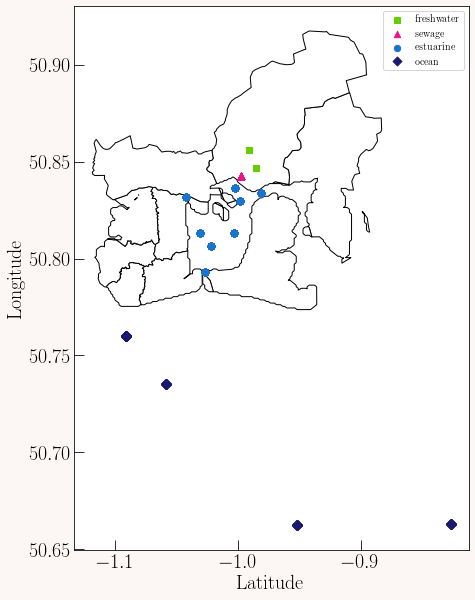

In [53]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

PO_district.plot(ax = ax, color='white', edgecolor='black')

gdf_freshwater.plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="freshwater")
gdf_sewage.plot(ax=ax, color='#EE1289', markersize=40, marker="^", label="sewage")
gdf_estuarine.plot(ax=ax, color='#1874CD', markersize=40, marker="o", label="estuarine")
gdf_ocean.plot(ax=ax, color='#191970', markersize=40, marker="D", label="ocean")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.legend()


### 1.d) Considering the rivers

#### RIVER DATASET FROM https://www.ordnancesurvey.co.uk/business-government/products/open-map-rivers

In [57]:
rivers = gpd.read_file('./data/HydroNode.shp')


In [59]:
rivers_course = gpd.read_file('./data/WatercourseLink.shp')


In [60]:
rivers = rivers.to_crs(4326)

rivers_course = rivers_course.to_crs(4326)

In [61]:
polygon_geom = Polygon(gdf_loc.envelope)
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]).convex_hull   



In [62]:
mask_location = np.where(rivers.geometry.within(polygon.iloc[0])==True)
mask_location_course = (np.where(rivers_course.geometry.intersects(polygon.iloc[0])==True))



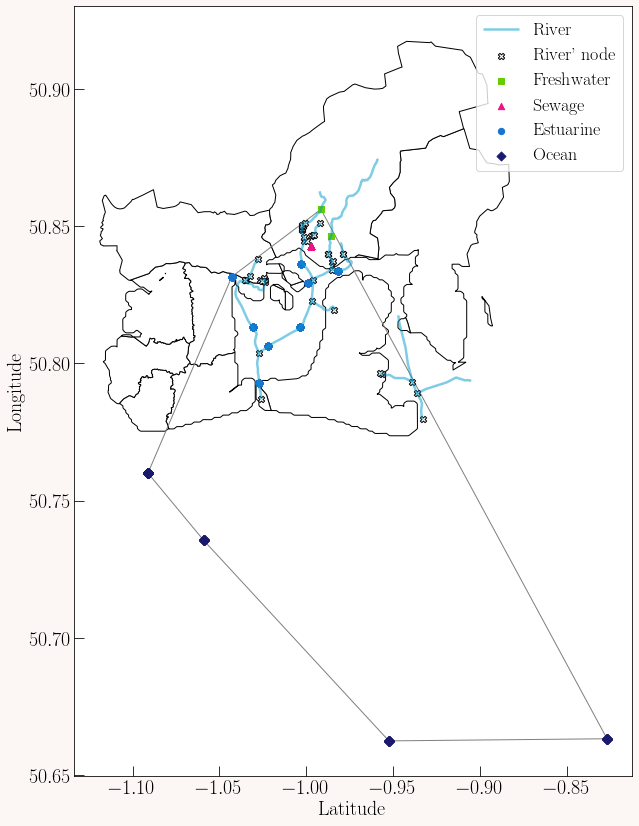

In [63]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 20)

PO_district.plot(ax = ax, color='white', edgecolor='black')
polygon.plot(ax = ax, color='None', edgecolor='grey')

rivers_course.iloc[mask_location_course].plot(ax = ax, color='#009ACD', markersize=10, alpha=0.5, label="River")
rivers.iloc[mask_location].plot(ax = ax, color='white', edgecolor="black", markersize=40, alpha=1, marker="X", label="River' node")

gdf_freshwater.plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="Freshwater")
gdf_sewage.plot(ax=ax, color='#EE1289', markersize=40, marker="^", label="Sewage")
gdf_estuarine.plot(ax=ax, color='#1874CD', markersize=40, marker="o", label="Estuarine")
gdf_ocean.plot(ax=ax, color='#191970', markersize=40, marker="D", label="Ocean")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

plt.legend(fontsize=18)


### 1.e) Considering the chemicals of interest in the Langstone report

In [64]:
DAIN_names = list(np.unique(df[df["determinand.notation"].isin([119, 111, 9993,116,9943])]["determinand.definition"]))

In [65]:
DAIP_names = list(np.unique(df[df["determinand.notation"].isin([180, 9856])]["determinand.definition"]))

In [66]:
Chl_Sal_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_Chl_Salinity)]["determinand.definition"]))

### 1.f) Repeating the plot in the Langstone report

In [67]:
scatter_params_fig2 = [{'c':'#EE6A50', 'marker':'+', 's':35, 'alpha':0.85}, {'c':'#48D1CC', 'marker':'.', 's':40, 'alpha':0.85}]


In [68]:
scatter_params_fig3 = [{'c':'#EE6A50', 'marker':'x', 's':35, 'alpha':0.85}, {'c':'#ADFF2F', 'marker':'x', 's':35, 'alpha':0.85},
                      {'c':'#87CEFA', 'marker':'x', 's':35, 'alpha':0.85}, {'c':'#E066FF', 'marker':'x', 's':35, 'alpha':0.85}]


In [69]:
fw_notation = np.unique(df_fw["sample.samplingPoint.notation"])

In [70]:
sew_notation = np.unique(df_sew["sample.samplingPoint.notation"]) 

In [71]:
bkg_notation = np.unique(df_ocean["sample.samplingPoint.notation"])

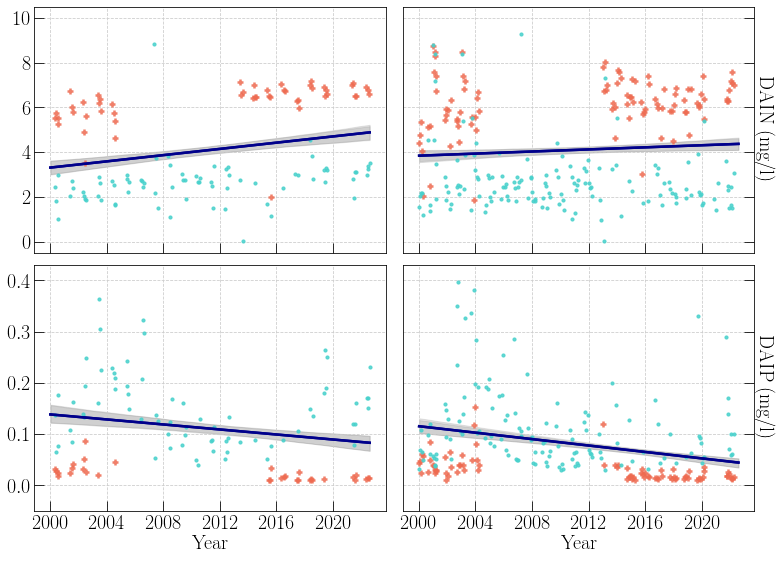

In [72]:
fig, axes = plt.subplots(nrows=len(fw_notation),ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

for i, fw_not in enumerate(fw_notation):
    rf.plot_sum_summer(df_fw, fw_not, DAIN_names, ax=axes[0,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_fw, fw_not, DAIN_names, ax=axes[0,1], sct_kwargs = scatter_params_fig2[i])
    
    rf.LinearRegression_boot_summer(df_fw, fw_notation, DAIN_names, ax=axes[0,0])
    rf.LinearRegression_boot_winter(df_fw, fw_notation, DAIN_names, ax=axes[0,1])
    
    rf.plot_sum_summer(df_fw, fw_not, DAIP_names, ax=axes[1,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_fw, fw_not, DAIP_names, ax=axes[1,1], sct_kwargs = scatter_params_fig2[i])
    
    rf.LinearRegression_boot_summer(df_fw, fw_notation, DAIP_names, ax=axes[1,0])
    rf.LinearRegression_boot_winter(df_fw, fw_notation, DAIP_names, ax=axes[1,1])


axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[0, 1].set_ylim([-.5, 10.5])
axes[0, 0].set_ylim([-.5, 10.5])

axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylim([-.05, 0.43])
axes[1, 1].set_ylim([-.05, 0.43])
axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

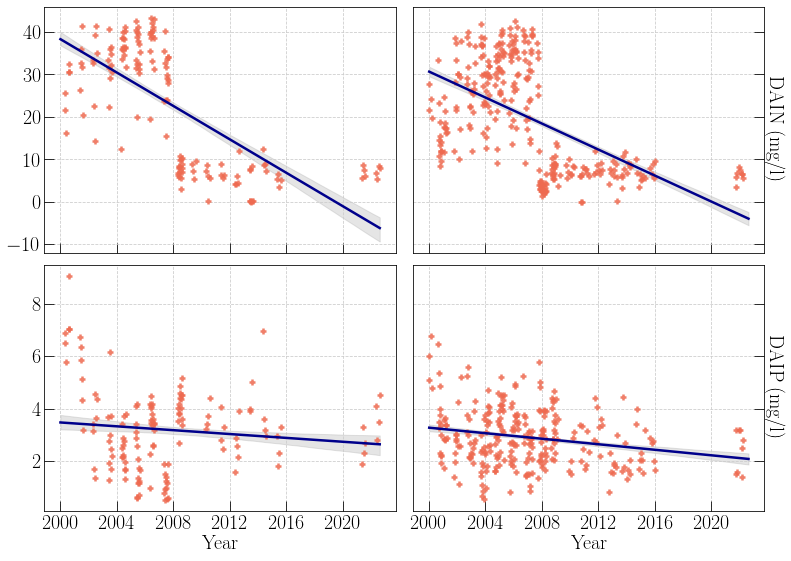

In [73]:
fig, axes = plt.subplots(nrows=len(fw_notation),ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


for i, fw_not in enumerate(sew_notation):
    rf.plot_sum_summer(df_sew, fw_not, DAIN_names, ax=axes[0,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_sew, fw_not, DAIN_names, ax=axes[0,1], sct_kwargs = scatter_params_fig2[i])

    rf.LinearRegression_boot_summer(df_sew, fw_not, DAIN_names, ax=axes[0,0])
    rf.LinearRegression_boot_winter(df_sew, fw_not, DAIN_names, ax=axes[0,1])
    
    
    rf.plot_sum_summer(df_sew, fw_not, DAIP_names, ax=axes[1,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_sew, fw_not, DAIP_names, ax=axes[1,1], sct_kwargs = scatter_params_fig2[i])

    
    rf.LinearRegression_boot_summer(df_sew, fw_not, DAIP_names, ax=axes[1,0])
    rf.LinearRegression_boot_winter(df_sew, fw_not, DAIP_names, ax=axes[1,1])
    
    
axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)


axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")

axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

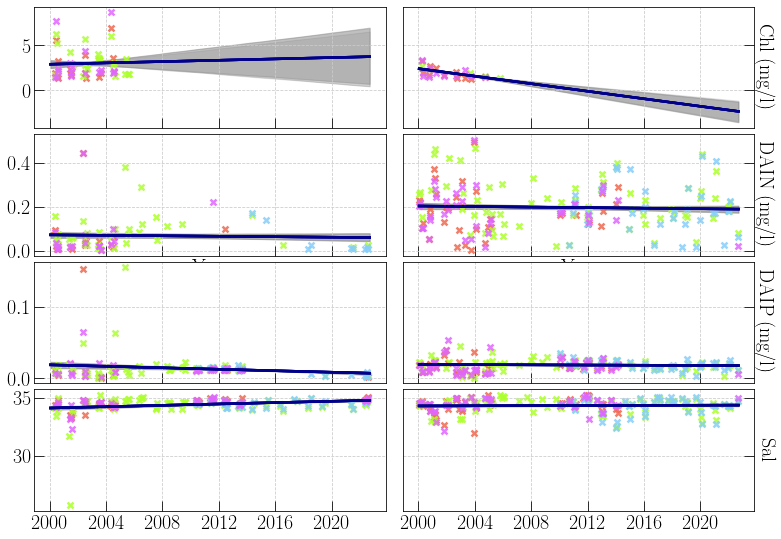

In [74]:
fig, axes = plt.subplots(nrows=4,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


for i, fw_not in enumerate(bkg_notation):
    
    rf.plot_sum_summer(df_ocean, fw_not, [Chl_Sal_names[0]], ax=axes[0,0], sct_kwargs = scatter_params_fig3[i])
    rf.plot_sum_winter(df_ocean, fw_not, [Chl_Sal_names[0]], ax=axes[0,1], sct_kwargs = scatter_params_fig3[i])

    rf.LinearRegression_boot_summer(df_ocean, bkg_notation, [Chl_Sal_names[0]], ax=axes[0,0])
    rf.LinearRegression_boot_winter(df_ocean, bkg_notation, [Chl_Sal_names[0]], ax=axes[0,1])
    
    
    
    rf.plot_sum_summer(df_ocean, fw_not, DAIN_names, ax=axes[1,0], sct_kwargs = scatter_params_fig3[i])
    rf.plot_sum_winter(df_ocean, fw_not, DAIN_names, ax=axes[1,1], sct_kwargs = scatter_params_fig3[i])

    rf.LinearRegression_boot_summer(df_ocean, bkg_notation, DAIN_names, ax=axes[1,0])
    rf.LinearRegression_boot_winter(df_ocean, bkg_notation, DAIN_names, ax=axes[1,1])
    
    
    rf.plot_sum_summer(df_ocean, fw_not, DAIP_names, ax=axes[2,0], sct_kwargs = scatter_params_fig3[i])
    rf.plot_sum_winter(df_ocean, fw_not, DAIP_names, ax=axes[2,1], sct_kwargs = scatter_params_fig3[i])

    
    rf.LinearRegression_boot_summer(df_ocean, bkg_notation, DAIP_names, ax=axes[2,0])
    rf.LinearRegression_boot_winter(df_ocean, bkg_notation, DAIP_names, ax=axes[2,1])

    rf.plot_sum_summer(df_ocean, fw_not, [Chl_Sal_names[1]], ax=axes[3,0], sct_kwargs = scatter_params_fig3[i])
    rf.plot_sum_winter(df_ocean, fw_not, [Chl_Sal_names[1]], ax=axes[3,1], sct_kwargs = scatter_params_fig3[i])

    rf.LinearRegression_boot_summer(df_ocean, bkg_notation, [Chl_Sal_names[1]], ax=axes[3,0])
    rf.LinearRegression_boot_winter(df_ocean, bkg_notation, [Chl_Sal_names[1]], ax=axes[3,1])

axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("Chl (mg/l)", rotation=270, labelpad=20)


axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)


axes[2, 1].yaxis.tick_right()

axes[2, 1].yaxis.set_label_position("right")

axes[2, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)



axes[3, 1].yaxis.tick_right()# 2) Average and median of DAIN, DAIP, Chl, and  Sal from South to North

axes[3, 1].yaxis.set_label_position("right")

axes[3, 1].set_ylabel("Sal", rotation=270, labelpad=20)


axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")

axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[2, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[2, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[3, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[3, 1].grid(which='major', color='#CCCCCC', linestyle='--')

### 1.g) Studying the evolution of these chemicals assuming the average and median values over a present-day (2015-2022) and baseline (2000-2005) period, for the different location, arranged going from the South to the North compared to the Sewage location in the harbour


#### Selecting the locations of interest

In [75]:
location_list_NtoS = ['SO-G0003493',  'SO-G0016920', 'SO-G0003484', 'SO-G0016918',   'SO-G0015927', 'SO-G0003468', 'SO-G0003467', 'SO-G0016921' ]

In [76]:
df_langstone_SN = df_water[df_water["sample.samplingPoint.notation"].isin(location_list_NtoS)]

In [77]:
unique_loc_id_SN = np.unique(df_langstone_SN["sample.samplingPoint.label"], return_index=True)[1]

#### rearranging them from south to north

In [78]:
df_langstone_SN_ = df_langstone_SN.iloc[unique_loc_id_SN].sort_values(by="sample.samplingPoint.northing", ascending=True)

In [79]:
gdf_StN = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_langstone_SN_["sample.samplingPoint.easting"], \
                                                      df_langstone_SN_["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)

In [80]:
from matplotlib import cm


colors = cm.summer(np.linspace(0, 1, len(gdf_StN)))



##### The location are reported from the Southest location (green point) to the Northest one (yellow point):
##### The sewage point is represented by the pink triangle

Text(40.52818288838729, 0.5, 'Longitude')

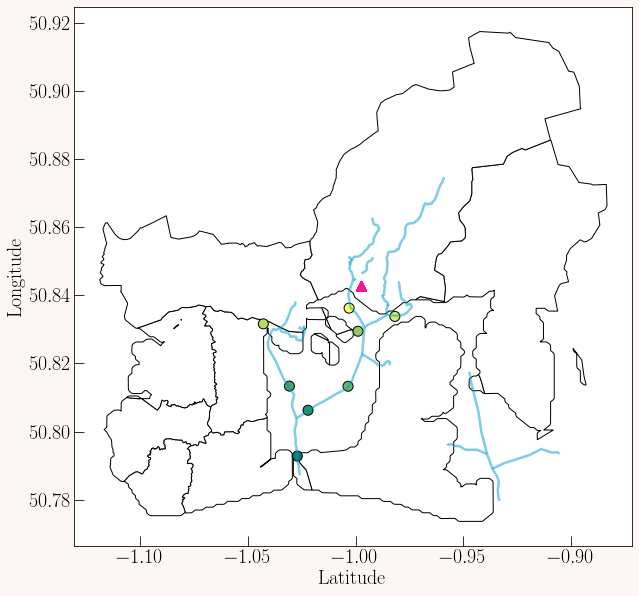

In [81]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 20)

PO_district.plot(ax = ax, color='white', edgecolor='black')

rivers_course.iloc[mask_location_course].plot(ax = ax, color='#009ACD', markersize=10, alpha=0.5)
gdf_StN.plot(ax=ax, color=colors, edgecolor="black", markersize=100, marker="o")
gdf_sewage.plot(ax=ax, color="deeppink",  markersize=100, marker="^")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


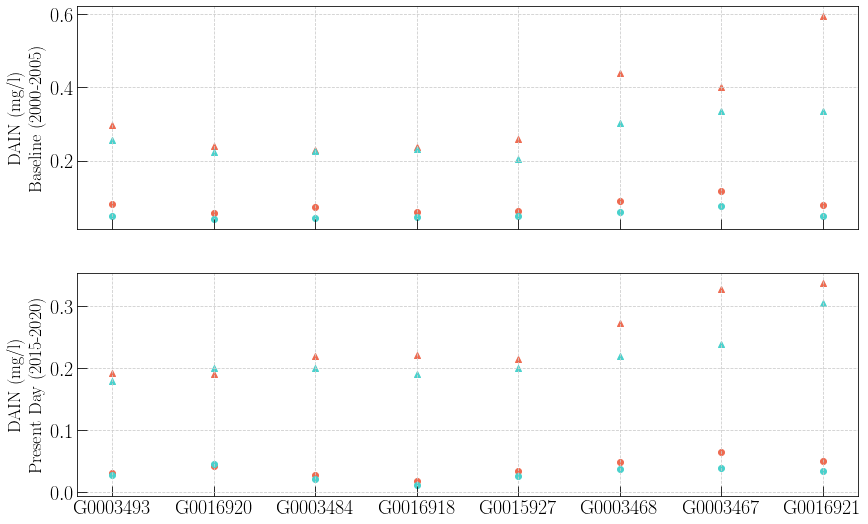

In [82]:
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(14,9))

for i, not_ in enumerate(location_list_NtoS):
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]<2005], str(not_), DAIN_names)
    axes[0].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")

    axes[0].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

    axes[0].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[0].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]>2015], str(not_), DAIN_names)
    axes[1].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    axes[1].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

axes[1].set_xticklabels(["", "G0003493", "G0016920", "G0003484", "G0016918", "G0015927", \
               "G0003468", "G0003467", "G0016921"]);

axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0].grid(which='major', color='#CCCCCC', linestyle='--')

axes[1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[0].set_ylabel("DAIN (mg/l) \n Baseline (2000-2005)", fontsize=18)
axes[1].set_ylabel("DAIN (mg/l) \n Present Day (2015-2020)", fontsize=18);

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


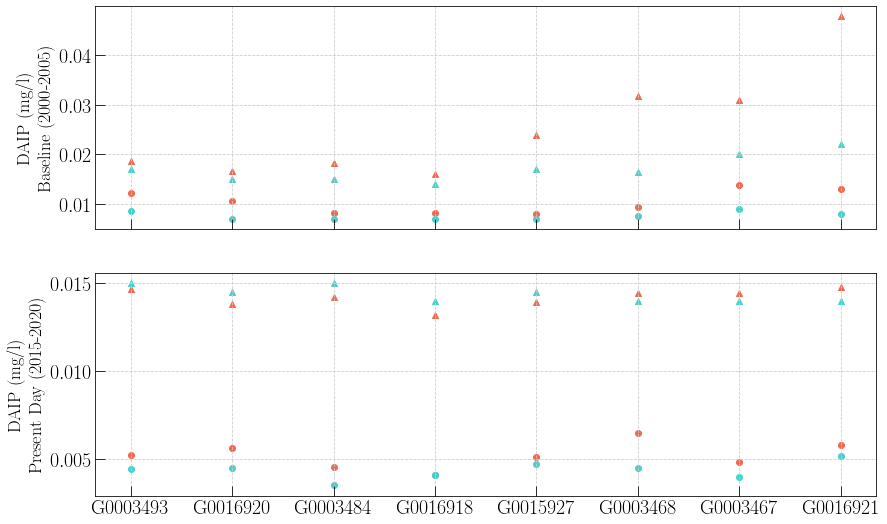

In [83]:
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(14,9))

for i, not_ in enumerate(location_list_NtoS):
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]<2005], str(not_), DAIP_names)
    axes[0].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")

    axes[0].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

    axes[0].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[0].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]>2015], str(not_), DAIP_names)
    axes[1].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    axes[1].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

axes[1].set_xticklabels(["", "G0003493", "G0016920", "G0003484", "G0016918", "G0015927", \
               "G0003468", "G0003467", "G0016921"]);

axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0].grid(which='major', color='#CCCCCC', linestyle='--')

axes[1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[0].set_ylabel("DAIP (mg/l) \n Baseline (2000-2005)", fontsize=18)
axes[1].set_ylabel("DAIP (mg/l) \n Present Day (2015-2020)", fontsize=18);

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/nannil/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


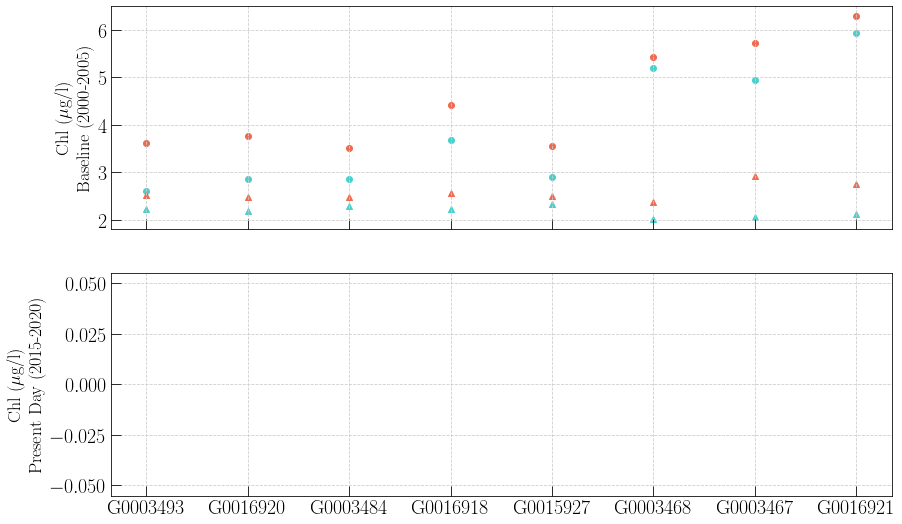

In [84]:
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(14,9))

for i, not_ in enumerate(location_list_NtoS):
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]<=2005], str(not_), [Chl_Sal_names[0]])
    axes[0].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")

    axes[0].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

    axes[0].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[0].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]>=2015], str(not_), [Chl_Sal_names[0]])
    axes[1].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")
    axes[1].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

axes[1].set_xticklabels(["", "G0003493", "G0016920", "G0003484", "G0016918", "G0015927", \
               "G0003468", "G0003467", "G0016921"]);

axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0].grid(which='major', color='#CCCCCC', linestyle='--')

axes[1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[0].set_ylabel("Chl ($\mu$g/l) \n Baseline (2000-2005)", fontsize=18)
axes[1].set_ylabel("Chl ($\mu$g/l) \n Present Day (2015-2020)", fontsize=18);

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


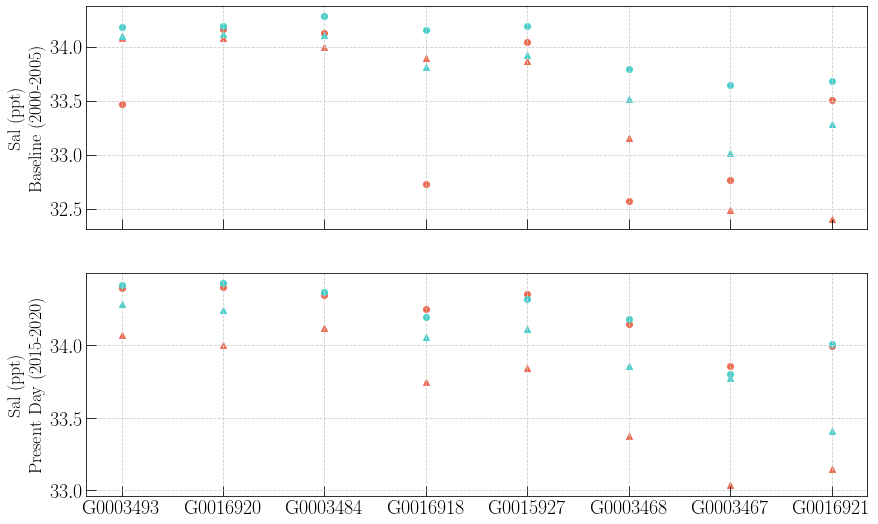

In [85]:
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(14,9))

x_loc = []


for i, not_ in enumerate(location_list_NtoS):
    df_s, df_w = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]<=2005], str(not_), [Chl_Sal_names[1]])
    axes[0].scatter( i , np.nanmean(df_s["sum"]), marker="o", color="#EE6A50")
    axes[0].scatter( i , np.nanmedian(df_s["sum"]), marker="o", color="#48D1CC")

    
    axes[0].scatter( i , np.nanmean(df_w["sum"]), marker="^", color="#EE6A50")
    axes[0].scatter( i , np.nanmedian(df_w["sum"]), marker="^", color="#48D1CC")

    
    df_s_b, df_w_b = rf.sum_seasons(df_langstone_report[df_langstone_report["year"]>=2015], str(not_), [Chl_Sal_names[1]])
    axes[1].scatter( i , np.nanmean(df_w_b["sum"]), marker="^", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_w_b["sum"]), marker="^", color="#48D1CC")

    
    axes[1].scatter( i , np.nanmean(df_s_b["sum"]), marker="o", color="#EE6A50")
    axes[1].scatter( i , np.nanmedian(df_s_b["sum"]), marker="o", color="#48D1CC")




axes[1].set_xticklabels(["", "G0003493", "G0016920", "G0003484", "G0016918", "G0015927", \
               "G0003468", "G0003467", "G0016921"]);

axes[0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0].grid(which='major', color='#CCCCCC', linestyle='--')

axes[1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[0].set_ylabel("Sal (ppt) \n Baseline (2000-2005)", fontsize=18)
axes[1].set_ylabel("Sal (ppt) \n Present Day (2015-2020)", fontsize=18);

## 2) Predicting missing data with Gaussian Processes

##### Since there are missing dates, we can try and predict those observations with the GP

### 2.0) Definition of the kernel for the GP

In [86]:
kernel = rf.GP_kernel(noise_level_=1)

In [87]:
GP_DAIN_0 = rf.GP_imputing(df_fw, fw_notation[0], DAIN_names, kernel=kernel)
GP_DAIP_0 = rf.GP_imputing(df_fw, fw_notation[0], DAIP_names, kernel=kernel)

GP_DAIN_1 = rf.GP_imputing(df_fw, fw_notation[1], DAIN_names, kernel=kernel)
GP_DAIP_1 = rf.GP_imputing(df_fw, fw_notation[1], DAIP_names, kernel=kernel)


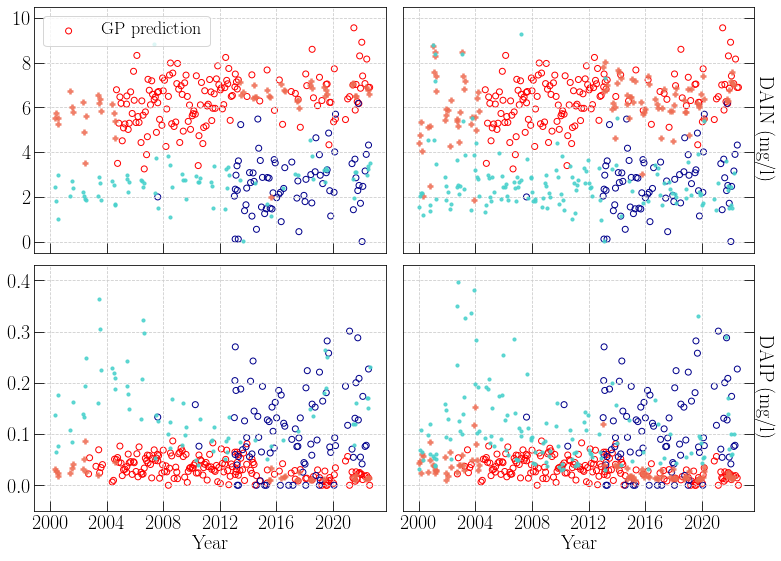

In [88]:
fig, axes = plt.subplots(nrows=len(fw_notation),ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


axes[0,0].scatter(GP_DAIN_0[0], GP_DAIN_0[1], edgecolor="red", facecolor="None", label="GP prediction")
axes[0,1].scatter(GP_DAIN_0[0], GP_DAIN_0[1], edgecolor="red", facecolor="None")



axes[1,0].scatter(GP_DAIP_0[0], GP_DAIP_0[1], edgecolor="red", facecolor="None")
axes[1,1].scatter(GP_DAIP_0[0], GP_DAIP_0[1], edgecolor="red", facecolor="None")



axes[0,0].scatter(GP_DAIN_1[0], GP_DAIN_1[1], edgecolor="darkblue", facecolor="None")
axes[0,1].scatter(GP_DAIN_1[0], GP_DAIN_1[1], edgecolor="darkblue", facecolor="None")



axes[1,0].scatter(GP_DAIP_1[0], GP_DAIP_1[1], edgecolor="darkblue", facecolor="None")
axes[1,1].scatter(GP_DAIP_1[0], GP_DAIP_1[1], edgecolor="darkblue", facecolor="None")


for i, fw_not in enumerate(fw_notation):
    rf.plot_sum_summer(df_fw, fw_not, DAIN_names, ax=axes[0,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_fw, fw_not, DAIN_names, ax=axes[0,1], sct_kwargs = scatter_params_fig2[i])
    
    rf.plot_sum_summer(df_fw, fw_not, DAIP_names, ax=axes[1,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_fw, fw_not, DAIP_names, ax=axes[1,1], sct_kwargs = scatter_params_fig2[i])
    


axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[0, 1].set_ylim([-.5, 10.5])
axes[0, 0].set_ylim([-.5, 10.5])

axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylim([-.05, 0.43])
axes[1, 1].set_ylim([-.05, 0.43])
axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

axes[0, 0].legend(fontsize=18)

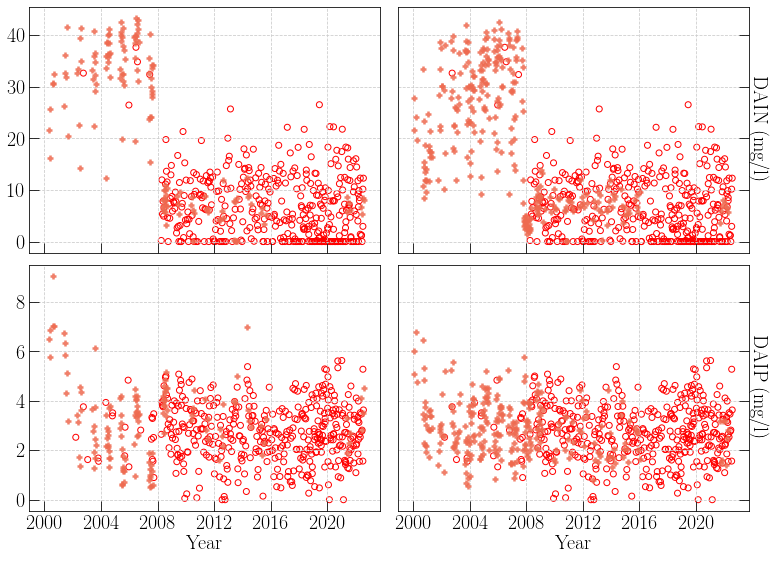

In [89]:
GP_DAIN_sew = rf.GP_imputing(df_sew, sew_notation[0], DAIN_names, kernel=kernel)


GP_DAIP_sew = rf.GP_imputing(df_sew, sew_notation[0], DAIP_names, kernel=kernel)



fig, axes = plt.subplots(nrows=len(fw_notation),ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


axes[0,0].scatter(GP_DAIN_sew[0], GP_DAIN_sew[1], edgecolor="red", facecolor="None")
axes[0,1].scatter(GP_DAIN_sew[0], GP_DAIN_sew[1], edgecolor="red", facecolor="None")



axes[1,0].scatter(GP_DAIP_sew[0], GP_DAIP_sew[1], edgecolor="red", facecolor="None")
axes[1,1].scatter(GP_DAIP_sew[0], GP_DAIP_sew[1], edgecolor="red", facecolor="None")




for i, not_ in enumerate(sew_notation):
    rf.plot_sum_summer(df_sew, not_, DAIN_names, ax=axes[0,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_sew, not_, DAIN_names, ax=axes[0,1], sct_kwargs = scatter_params_fig2[i])

    rf.plot_sum_summer(df_sew, not_, DAIP_names, ax=axes[1,0], sct_kwargs = scatter_params_fig2[i])
    rf.plot_sum_winter(df_sew, not_, DAIP_names, ax=axes[1,1], sct_kwargs = scatter_params_fig2[i])

axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)


axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")

axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

## 3) The possibility to automatically select closed water system and run the analysis



### 3.0) district in the UK
### data from here https://www.opendoorlogistics.com/downloads/

In [91]:
uk_regions_en = gpd.read_file('RGN_DEC_2021_EN_BFC.shp')
uk_SE_en = uk_regions_en[(uk_regions_en['RGN21NM'] == ("South East") )].geometry

uk_SE_ll = uk_SE_en.to_crs(4326) # the map in longitude latitude

uk_SW_en = uk_regions_en[(uk_regions_en['RGN21NM'] == "South West")].geometry #eastimgs northings for southwest

uk_SW_ll = uk_SW_en.to_crs(4326) # in long and lat

regions_en = uk_SW_en.append(uk_SE_en)

regions_ll = uk_SW_ll.append(uk_SE_ll)


### 3.1) Ocean in the UK

In [92]:
uk_diss = uk_regions_en.dissolve()

In [93]:
UK_region = uk_diss.convex_hull

In [94]:
UK_ocean = UK_region.difference(uk_diss).to_crs(4326)

<AxesSubplot:>

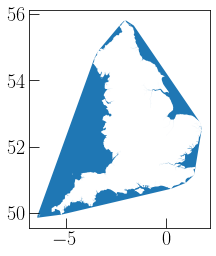

In [95]:
UK_ocean.plot()

In [96]:
df_SEWAGE = df_water[df_water["sample.sampledMaterialType.label"]==water_names[1]]


In [97]:
df_RIVER = df_water[df_water["sample.sampledMaterialType.label"]==water_names[0]]


In [98]:
df_SEA = df_water[df_water["sample.sampledMaterialType.label"]==water_names[2]]


In [99]:
df_ESTUARINE = df_water[df_water["sample.sampledMaterialType.label"]==water_names[3]]


In [100]:
df_OCEAN = df_water[df_water["sample.sampledMaterialType.label"]==water_names[2]]


In [101]:
len(np.unique(df_SEWAGE["sample.samplingPoint.label"])), len(np.unique(df_RIVER["sample.samplingPoint.label"])),len(np.unique(df_ESTUARINE["sample.samplingPoint.label"])), len(np.unique(df_OCEAN["sample.samplingPoint.label"]))

(793, 952, 246, 267)

In [102]:
gdf_loc_SEWAGE = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_SEWAGE["sample.samplingPoint.easting"], \
                                                      df_SEWAGE["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)


In [103]:
gdf_loc_ESTUARINE = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_ESTUARINE["sample.samplingPoint.easting"], \
                                                      df_ESTUARINE["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)



In [104]:
gdf_loc_RIVER = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_RIVER["sample.samplingPoint.easting"], \
                                                      df_RIVER["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)



In [105]:
gdf_loc_OCEAN = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_OCEAN["sample.samplingPoint.easting"], \
                                                      df_OCEAN["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)



### 3.2) South-Est UK

In [106]:
uk_SE_llgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(uk_SE_ll))

In [107]:
river_SE = gpd.sjoin(uk_SE_llgdf, rivers_course, how = 'inner', predicate ='contains')

Text(187.43977963853814, 0.5, 'Longitude')

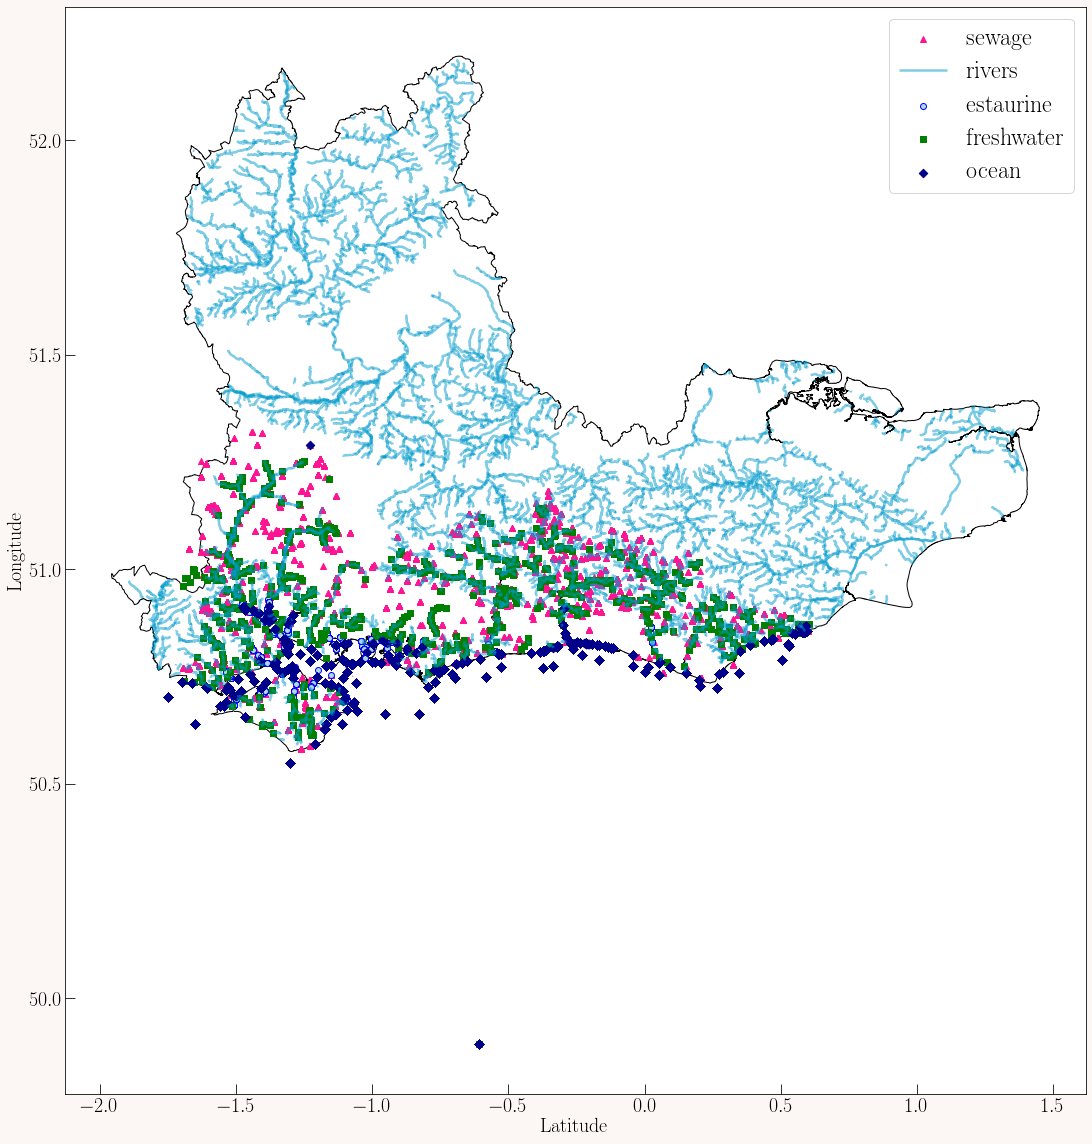

In [108]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(20, 20)


uk_SE_ll.plot(ax=ax, color='white', edgecolor='black')
gdf_loc_SEWAGE.plot(ax=ax, color="deeppink", marker="^", label="sewage")
rivers_course.loc[river_SE.index_right].plot(ax = ax, color='#009ACD', markersize=10, alpha=0.5, label="rivers")

gdf_loc_ESTUARINE.plot(ax=ax, color="lightblue", edgecolor="blue", marker="o", label="estaurine")

gdf_loc_RIVER.plot(ax=ax, color="green", marker="s", label="freshwater")

gdf_loc_OCEAN.plot(ax=ax, color="darkblue", marker="D", label="ocean")

plt.legend(fontsize=24)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

### 3.3) Selecting Postcodes

In [109]:
SO_postcodes = ["{}{}".format("SO", i) for i in (14,15, 16, 17, 18, 19, 31,30,40, 45)]



In [110]:

SO_district = uk_district[(uk_district['name'].isin(SO_postcodes) )].geometry

SO_district = SO_district.to_crs(4326)

Text(121.3900874649751, 0.5, 'Longitude')

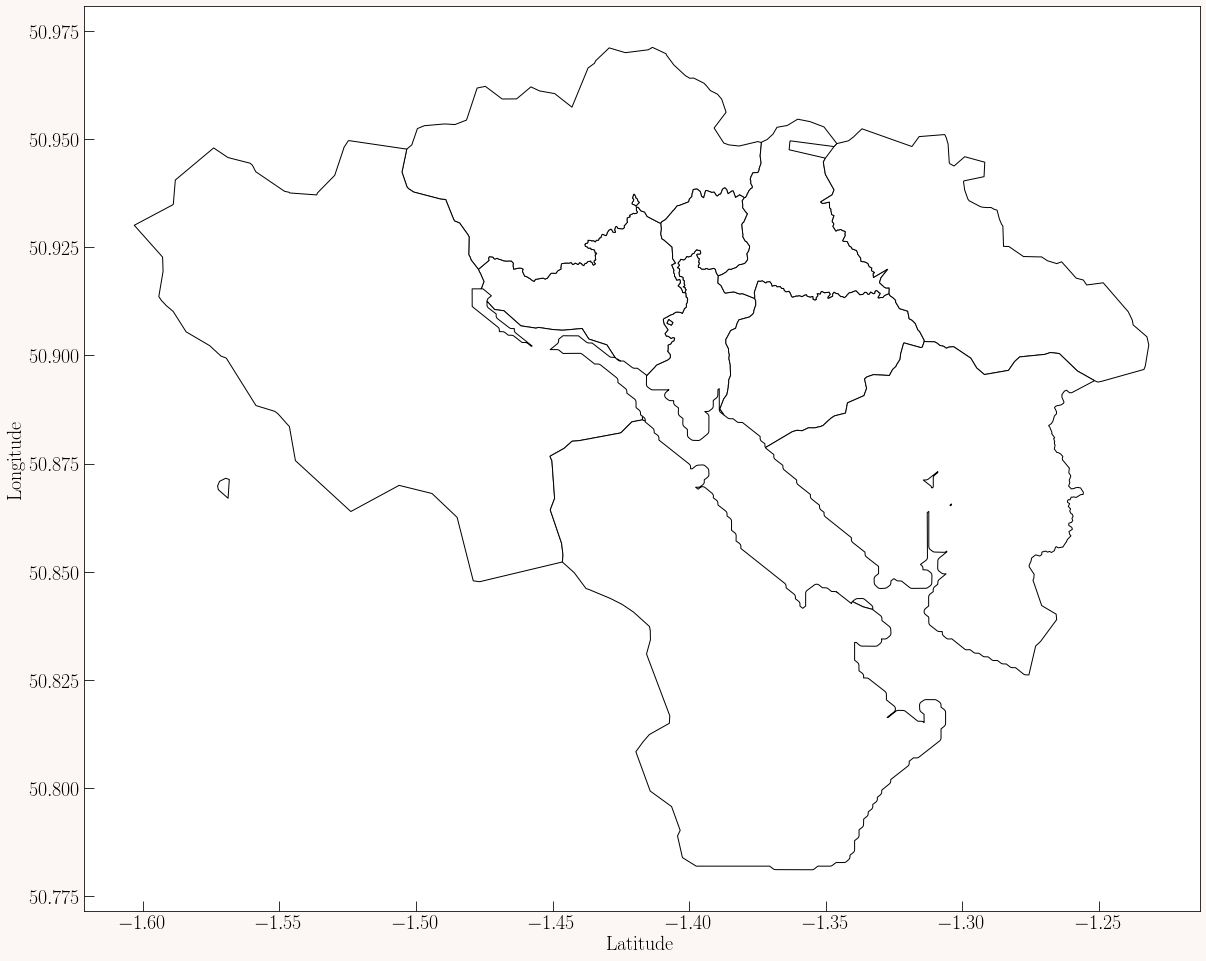

In [111]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(20, 20)


SO_district.plot(ax=ax, color='white', edgecolor='black')

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

## 3.4) Selecting locations in the selected postcodes

In [112]:
gdf_loc_all = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_water["sample.samplingPoint.easting"], \
                                                      df_water["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)



In [113]:
gdf_loc_all["geometry"] = gdf_loc_all.geometry

In [114]:
SO_district = gpd.GeoDataFrame(geometry=gpd.GeoSeries(SO_district))

In [115]:
SO_locations = gpd.sjoin(gdf_loc_all, SO_district, how = 'inner', predicate ='within')

Text(121.3900874649751, 0.5, 'Longitude')

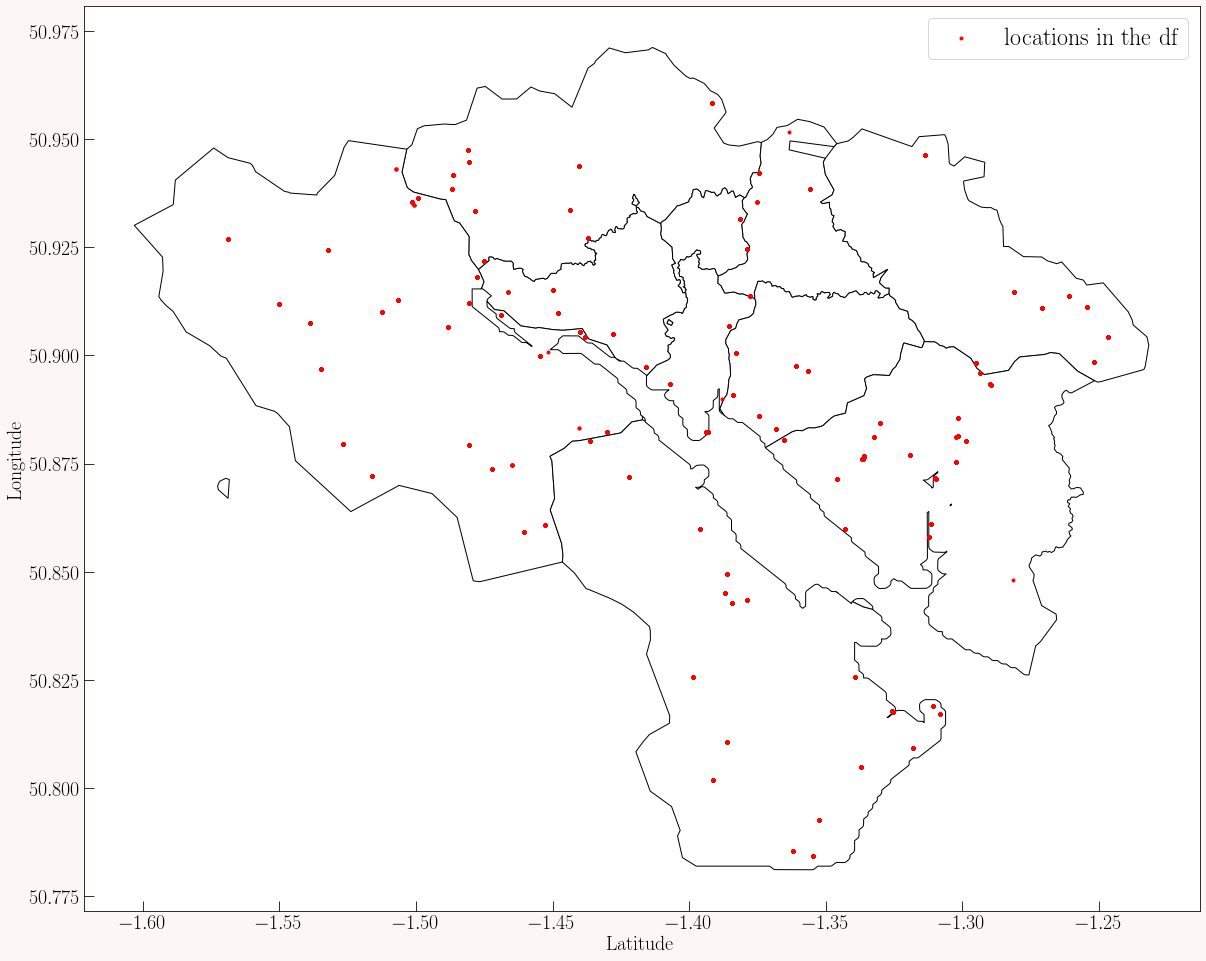

In [116]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(20, 20)


SO_district.plot(ax=ax, color='white', edgecolor='black')
gdf_loc_all.iloc[SO_locations.index.values].plot(ax=ax, color="red", marker=".", label="locations in the df")

plt.legend(fontsize=24)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

### 3.5) Building the polygon containing all the locations

In [117]:
SO_points = gdf_loc_all.iloc[SO_locations.index.values]

In [118]:
gdf_SO_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(SO_points.geometry.x, \
                                                      SO_points.geometry.y), crs=4326)



In [119]:
polygon_geom_SO = Polygon(gdf_SO_points.envelope)


In [120]:
crs = 'epsg:4326'
polygon_SO = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom_SO]).convex_hull

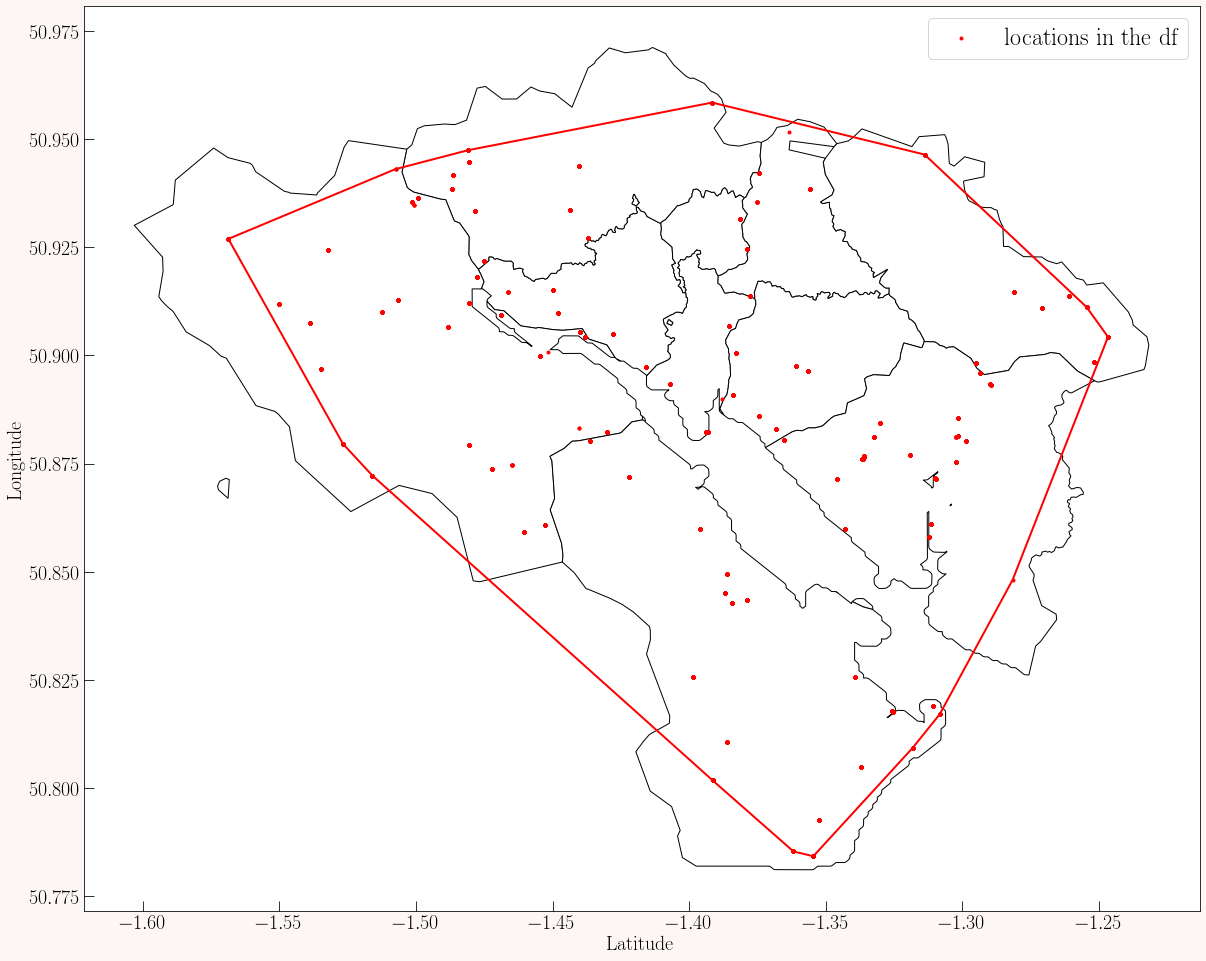

In [121]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(20, 20)


SO_district.plot(ax=ax, color='white', edgecolor='black')
gdf_loc_all.iloc[SO_locations.index.values].plot(ax=ax, color="red", marker=".", label="locations in the df")

polygon_SO.plot(ax = ax, color='None', edgecolor='red', linewidth=2, label="polygon")


plt.legend(fontsize=24)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

 ### 3.6) Now, we select all the points in the polygon and all the rivers in the polygon

In [122]:
mask_location_SO = np.where(rivers.geometry.within(polygon_SO.iloc[0])==True)
mask_location_course_SO = (np.where(rivers_course.geometry.intersects(polygon_SO.iloc[0])==True))


In [123]:
poly1 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygon_SO))
poly2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(UK_ocean))

In [124]:
df_southampton = df_water.iloc[np.where(gdf_loc_all.within(polygon_SO.iloc[0])==True)[0]]


In [125]:
df_fw_SO = df_southampton[df_southampton["sample.sampledMaterialType.label"]==water_names[0]]
df_sew_SO = df_southampton[df_southampton["sample.sampledMaterialType.label"]==water_names[1]]
df_ocean_SO = df_southampton[df_southampton["sample.sampledMaterialType.label"]==water_names[2]]
df_est_SO = df_southampton[df_southampton["sample.sampledMaterialType.label"]==water_names[3]]

gdf_freshwater_SO = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_fw_SO["sample.samplingPoint.easting"], \
                                                      df_fw_SO["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)


gdf_sewage_SO = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_sew_SO["sample.samplingPoint.easting"], \
                                                      df_sew_SO["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)


gdf_ocean_SO = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_ocean_SO["sample.samplingPoint.easting"], \
                                                      df_ocean_SO["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)


gdf_estuarine_SO = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_est_SO["sample.samplingPoint.easting"], \
                                                      df_est_SO["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)



In [126]:
SO_sea = gpd.overlay(poly2, poly1, how='intersection')

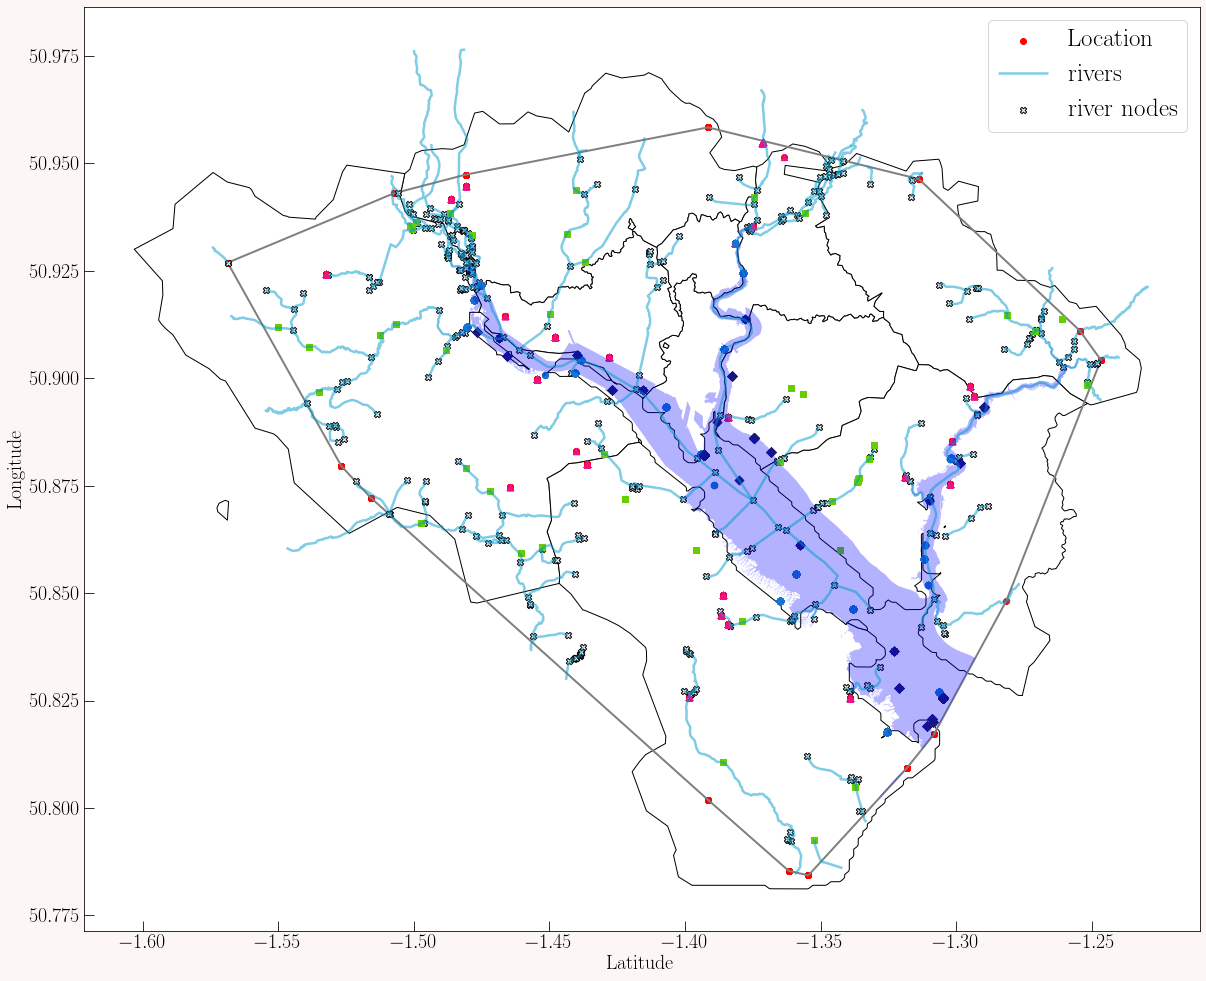

In [127]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(20, 20)

SO_district.plot(ax=ax, color='white', edgecolor='black')
gdf_loc_all.iloc[SO_locations.index.values].plot(ax=ax, color="red", marker="o", label="Location")
polygon_SO.plot(ax = ax, color='None', edgecolor='grey', linewidth=2)
rivers_course.iloc[mask_location_course_SO].plot(ax = ax, color='#009ACD', markersize=10, alpha=0.5, label="rivers")
rivers.iloc[mask_location_SO].plot(ax = ax, color='white', edgecolor="black", markersize=40, alpha=1, marker="X", label="river nodes")

gdf_freshwater_SO.plot(ax=ax, color='#66CD00', markersize=40, marker="s")
gdf_sewage_SO.plot(ax=ax, color='#EE1289', markersize=40, marker="^")
gdf_estuarine_SO.plot(ax=ax, color='#1874CD', markersize=40, marker="o")
gdf_ocean_SO.plot(ax=ax, color='#191970', markersize=40, marker="D")

SO_sea.plot(ax=ax , color="blue", alpha=0.3)
plt.legend(fontsize=25)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

In [128]:
united_river_course = shapely.ops.unary_union(rivers_course.iloc[mask_location_course_SO].geometry)

In [129]:
gdf_united_river_course = gpd.GeoDataFrame(geometry=gpd.GeoSeries(united_river_course)).explode()

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


In [130]:
gdf_water = pd.concat([SO_sea, gdf_united_river_course])

In [131]:
gdf_SO = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_southampton["sample.samplingPoint.easting"], \
                                                      df_southampton["sample.samplingPoint.northing"]), crs=27700).to_crs(4326)


#### 3.7) BUFFER THE POINTS


In [132]:
gdf_SO_buff = gdf_SO.to_crs(4326).buffer(0.005)

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [133]:
gdf_water_buff = gdf_water.to_crs(4326).buffer(0.0003)

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


#### 3.8) ASSOCIATE POINTS TO THE DIFFERENT WATER SYSTEM

In [134]:
united_water_course = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_water_buff.unary_union)).explode()


/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


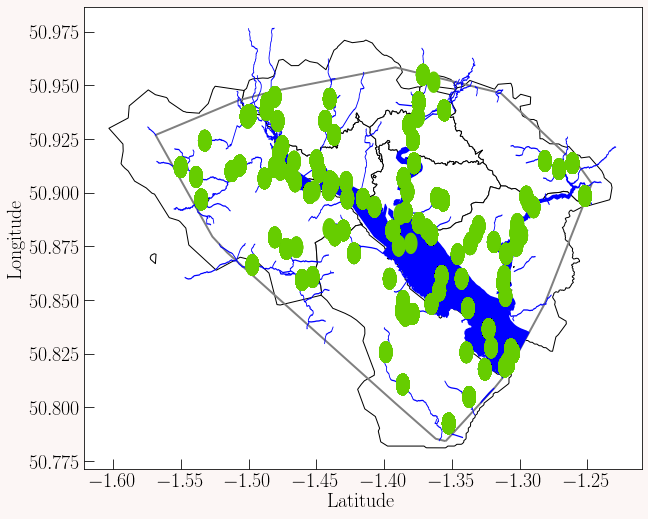

In [135]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

SO_district.plot(ax=ax, color='white', edgecolor='black')
polygon_SO.plot(ax = ax, color='None', edgecolor='grey', linewidth=2)
united_water_course.plot(ax = ax, color='blue', markersize=10, alpha=1, label="rivers")

gdf_SO_buff.plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="locations")


ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

In [136]:
gdf_SO_buff = gpd.GeoDataFrame(geometry=gpd.GeoSeries(gdf_SO_buff))

In [137]:
united_water = united_water_course.loc[0]

In [138]:
#join_SO_rivers = 
join_SO_rivers = gpd.sjoin(gdf_SO_buff, united_water, how = 'inner', op ='intersects')


/home/nannil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  


### 3.9) Selecting the points in one of the river system (the biggest)

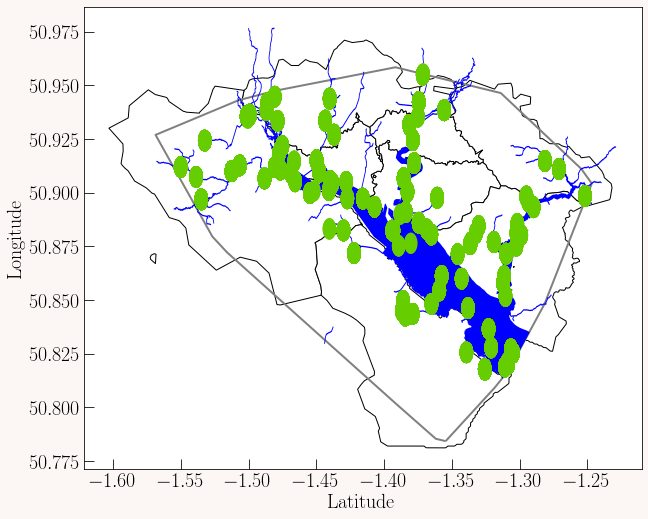

In [139]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

SO_district.plot(ax=ax, color='white', edgecolor='black')
polygon_SO.plot(ax = ax, color='None', edgecolor='grey', linewidth=2)


united_water.loc[4:5].plot(ax = ax, color='blue', markersize=10, alpha=1, label="rivers")

gdf_SO_buff.iloc[join_SO_rivers[join_SO_rivers["index_right"]==4].index].plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="locations")

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");


In [140]:
df_so_river = df_southampton.iloc[join_SO_rivers[join_SO_rivers["index_right"]==4].index]

In [141]:
df_fw = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[0]]
df_sew = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[1]]
df_ocean = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[2]]
df_est = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[3]]

In [142]:
fw_notation_so = np.unique(df_fw["sample.samplingPoint.notation"])

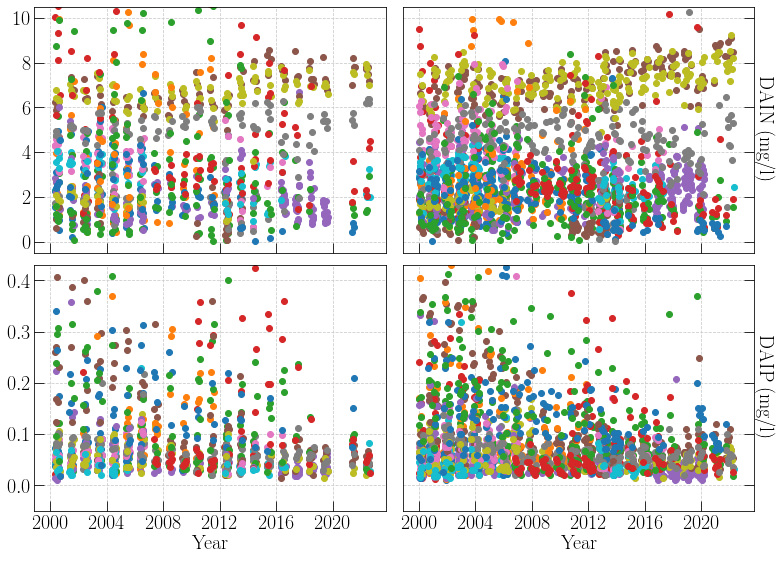

In [143]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


for i, not_ in enumerate(fw_notation_so):
    
    labels = not_
    rf.plot_sum_summer(df_fw, not_, DAIN_names, ax=axes[0,0])
    rf.plot_sum_winter(df_fw, not_, DAIN_names, ax=axes[0,1])
    
    rf.plot_sum_summer(df_fw, not_, DAIP_names, ax=axes[1,0])
    rf.plot_sum_winter(df_fw, not_, DAIP_names, ax=axes[1,1])


axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[0, 1].set_ylim([-.5, 10.5])
axes[0, 0].set_ylim([-.5, 10.5])

axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylim([-.05, 0.43])
axes[1, 1].set_ylim([-.05, 0.43])
axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

In [144]:
sew_notation_so = np.unique(df_sew["sample.samplingPoint.notation"]) 

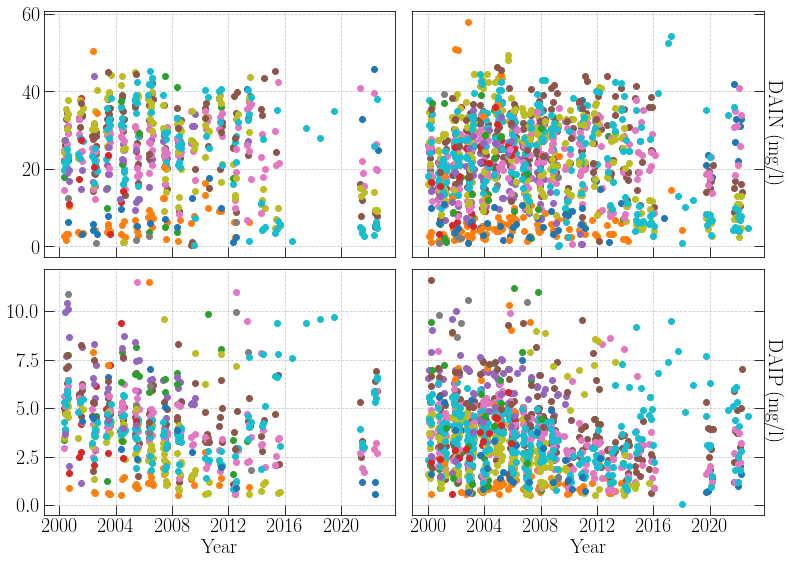

In [145]:

fig, axes = plt.subplots(nrows=2,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


for i, not_ in enumerate(sew_notation_so):
    rf.plot_sum_summer(df_sew, not_, DAIN_names, ax=axes[0,0])
    rf.plot_sum_winter(df_sew, not_, DAIN_names, ax=axes[0,1])

    rf.plot_sum_summer(df_sew, not_, DAIP_names, ax=axes[1,0])
    rf.plot_sum_winter(df_sew, not_, DAIP_names, ax=axes[1,1])

axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)


axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")

axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')

### 3.10) Selecting the points in on another the river system

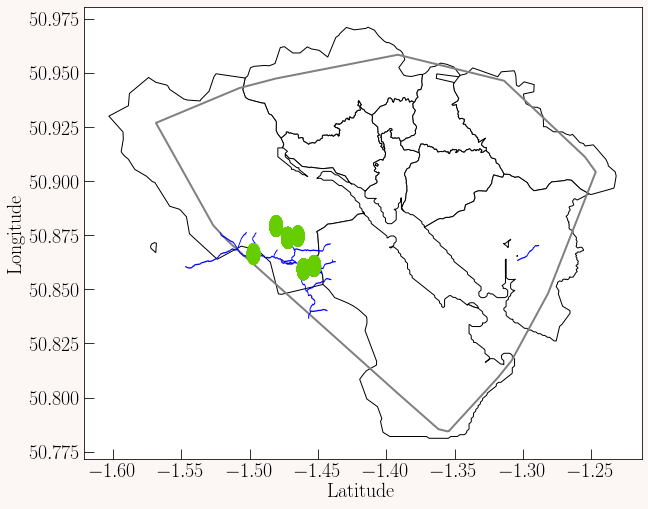

In [146]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

SO_district.plot(ax=ax, color='white', edgecolor='black')
polygon_SO.plot(ax = ax, color='None', edgecolor='grey', linewidth=2)


united_water.loc[6:7].plot(ax = ax, color='blue', markersize=10, alpha=1, label="rivers")

gdf_SO_buff.iloc[join_SO_rivers[join_SO_rivers["index_right"]==6].index].plot(ax=ax, color='#66CD00', markersize=40, marker="s", label="locations")

ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");


In [147]:
df_so_river = df_southampton.iloc[join_SO_rivers[join_SO_rivers["index_right"]==6].index]

In [148]:
df_fw = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[0]]
df_sew = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[1]]
df_ocean = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[2]]
df_est = df_so_river[df_so_river["sample.sampledMaterialType.label"]==water_names[3]]

In [149]:
fw_notation_so = np.unique(df_fw["sample.samplingPoint.notation"])

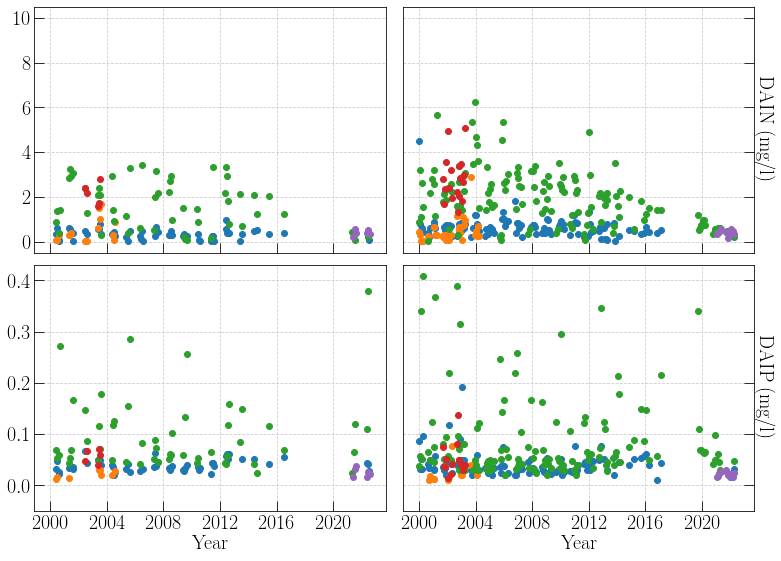

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)


for i, not_ in enumerate(fw_notation_so):
    
    labels = not_
    rf.plot_sum_summer(df_fw, not_, DAIN_names, ax=axes[0,0])
    rf.plot_sum_winter(df_fw, not_, DAIN_names, ax=axes[0,1])
    
    rf.plot_sum_summer(df_fw, not_, DAIP_names, ax=axes[1,0])
    rf.plot_sum_winter(df_fw, not_, DAIP_names, ax=axes[1,1])


axes[0, 1].yaxis.tick_right()

axes[0, 1].yaxis.set_label_position("right")

axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[0, 1].set_ylim([-.5, 10.5])
axes[0, 0].set_ylim([-.5, 10.5])

axes[1, 1].yaxis.tick_right()

axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)

axes[1, 1].set_xlabel("Year")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylim([-.05, 0.43])
axes[1, 1].set_ylim([-.05, 0.43])
axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')